## Reading Datasets

Dataset 1:Adult-all csv: https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv

Dataset 2: https://archive.ics.uci.edu/ml/datasets/covertype \
Outputs: 7 integers: different types of cover types for the trees\

Dataset 3: https://archive.ics.uci.edu/ml/datasets/Cardiotocography \
Outputs can be 3 or 10 depending on column we chose. numerical features. 

In [69]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time


try:
    from imblearn.under_sampling import RandomUnderSampler 
except:
    !pip install imblearn

rus = RandomUnderSampler(random_state=42)

# Read the data gill-attachmen

Names1 = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Result']
data1 = pd.read_csv('adult-all.csv', header=None,  index_col=False, names = Names1)
data1.drop_duplicates(inplace=True)
y=data1['Result']
X= data1[data1.columns[data1.columns != 'Result']]
X_res, y_res = rus.fit_resample(X, y)
data1 = pd.concat([X_res, y_res], axis=1)
data1.head()

data2 = pd.read_csv('bodyPerformance.csv')
data2.drop_duplicates(inplace=True)
data2.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


### Cleaning datasets and replacing missing values
Assuming that missing values are represented with '?' which is the case with dataset 1


In [70]:
#------------ replaces the missing values with the most frequent value ---------------
def missing_vals(data1):
    for col in data1.columns:
        if '?' in set(data1[col]):
            print (col)
            print('? values in',col, ":", data1[col].value_counts()['?'])
            data1[col].replace('?', np.nan, inplace=True)
            print('Replacing ? with most frequent:', data1[col].mode().iloc[0])
            data1[col].fillna(data1[col].mode().iloc[0], inplace=True)
            print()
        elif data1[col].isna().any():
            print (col, ": nan values present")
            
            
#---------- takes data and convert columns to categories and stores the mappings in a dict ---- 
def convert_cats_labels(data, columns=None, cats_names_dict={}):
    d1c = pd.DataFrame()
    if columns == None:
        for col in data.columns:
            d1c[col] = data[col].astype('category')
            cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
            d1c[col] = d1c[col].cat.codes
    
    else:
        for col in data.columns:
            if col in columns:
                d1c[col] = data[col].astype('category')
                cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
                d1c[col] = d1c[col].cat.codes
            else:
                d1c[col] = data[col]
                
    return d1c, cats_names_dict
            
missing_vals(data1)
missing_vals(data2)



cols_to_cats_d1 = ['workclass', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'native-country', 'Result']

data1, codes_d1 = convert_cats_labels(data1, columns = cols_to_cats_d1)



cols_to_cats_d2 = ['gender', 'class']

data2, codes_d2 = convert_cats_labels(data2, columns = cols_to_cats_d2)

workclass
? values in workclass : 1053
Replacing ? with most frequent: Private

occupation
? values in occupation : 1056
Replacing ? with most frequent: Exec-managerial

native-country
? values in native-country : 398
Replacing ? with most frequent: United-States



### Splitting the data 70-30

In [71]:
from sklearn.model_selection import train_test_split
    
X_data1 = data1[data1.columns[data1.columns != 'Result']]
y_data1 = data1.loc[:, 'Result']

X_data2 = data2[data2.columns[data2.columns != 'class']]
y_data2 = data2.loc[:, 'class']


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_data1, test_size=0.3, random_state=38)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_data2, test_size=0.3, random_state=38)
print("shape for data1 => training:", X_train1.shape, " and testing:", X_test1.shape)
print("shape for data2 => training:", X_train2.shape, " and testing:", X_test2.shape)

shape for data1 => training: (16353, 14)  and testing: (7009, 14)
shape for data2 => training: (9374, 11)  and testing: (4018, 11)


## Decision Trees

### Dataset 1

In [107]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree  import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn
import time

try:
    from graphviz import Source
except:
    ! pip3 install graphviz 
    
from IPython.display import SVG

def scoring_wo_cons_dt(X_train1, y_train1, X_test1, y_test1, data_name='Census pay'):
    print("Without constraints for Dataset:" + data_name)
    clf = DecisionTreeClassifier(random_state=10)
    
    start = time.time()
    clf.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")
    
    training_score = clf.score(X_train1, y_train1)
    start = time.time()
    testing_score = clf.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    print("Scoring time", round(testingtime, 4), "seconds")
    
    print("Training Accuracy", training_score)
    print("Testing Accuracy", testing_score)
    return clf

          

#--------------------- showing the image ----------------
def show_tree(X_train1, clf, show=False, name="DTcensus_unconstrained"):
    if show:
#           g = Source(export_graphviz(clf, out_file = None, feature_names = X_train1.columns, \
#                                 filled = True, rounded = True))
#           SVG(g.pipe(format='svg'))

        plt.figure(figsize=(40,20))  
        _ = tree.plot_tree(clf, feature_names = X_train1.columns, 
                     filled=True, fontsize=6, rounded = True)
        plt.show()
        plt.savefig(name+'.png')


sklearn.set_config(print_changed_only=False)

def print_tree_atts(clf):
    print("Max depth", clf.tree_.max_depth)
    print("Number of nodes", clf.tree_.node_count)
    print(clf)

          
# clf = scoring_wo_cons_dt(X_train1, y_train1)
# print_tree_atts(clf)

clf1_uc = scoring_wo_cons_dt(X_train1, y_train1, X_test1, y_test1, "census")
print_tree_atts(clf1)
print("-----------------------------------------------------------------")
clf2_uc = scoring_wo_cons_dt(X_train2, y_train2, X_test2, y_test2, "BodyPerf")
print_tree_atts(clf2)


Without constraints for Dataset:census
Training time 0.1023 seconds
Scoring time 0.0035 seconds
Training Accuracy 0.9998776982816608
Testing Accuracy 0.7567413325724069
Max depth 39
Number of nodes 5831
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')
-----------------------------------------------------------------
Without constraints for Dataset:BodyPerf
Training time 0.0711 seconds
Scoring time 0.002 seconds
Training Accuracy 1.0
Testing Accuracy 0.6428571428571429
Max depth 26
Number of nodes 3941
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impuri

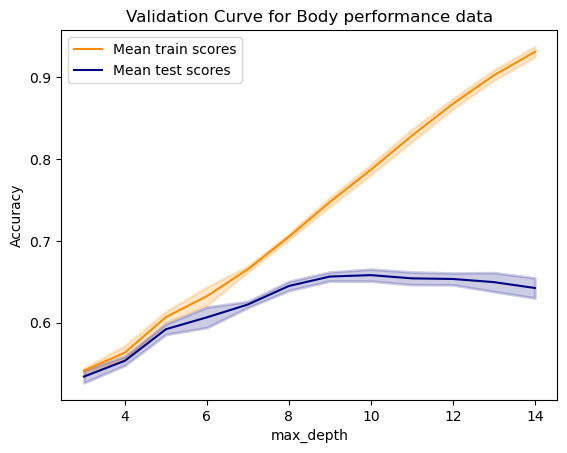

In [199]:
from sklearn.model_selection import validation_curve

max_depth_range = list(range(3,15))


def val_curve(estimator, X, y, param_name, param_range, scoring, ds_name):
    train_scores, test_scores = validation_curve(estimator, X, y,  param_name=param_name,
                                                 param_range=param_range, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    tit = "Validation Curve for " + ds_name
    plt.title(tit)
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
#     plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Mean train scores", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,      alpha=0.2,
        color="darkorange",  lw=lw )


    plt.plot(param_range, test_scores_mean, label="Mean test scores", color="navy",)
    
    plt.fill_between( param_range,  test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std,
        alpha=0.2, color="navy",    lw=lw,  )
    plt.legend(loc="best")
    plt.show()
    
    

tree = DecisionTreeClassifier(random_state = 50)
# val_curve(tree, X_train1, y_train1, "max_depth", max_depth_range, "accuracy", "Census pay data")
val_curve(tree, X_train2, y_train2, "max_depth", max_depth_range, "accuracy", "Body performance data")

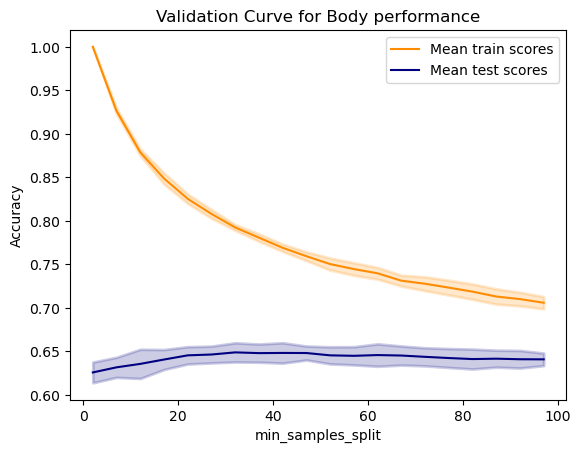

In [201]:
minsamplesplit_range = list(range(2,100,5))
tree = DecisionTreeClassifier(random_state = 50)
# val_curve(tree, X_train1, y_train1, "min_samples_split", minsamplesplit_range, "accuracy", "Census pay")
val_curve(tree, X_train2, y_train2, "min_samples_split", minsamplesplit_range, "accuracy", "Body performance")

### Pruning the trees

In [202]:
#--------------------------- early pruning ---------------- 
from sklearn.model_selection import RandomizedSearchCV

def prepruning_search (X_train1, y_train1, X_test1, y_test1, ds_name = 'census pay',
                       need_training = False, name_file='decision_tree'):
    if need_training == True:
        param_dist = {"max_depth": [10],
#                       "max_features": [1, 5, 8, 10, 13, 'sqrt'],
                      
                      "criterion": ["gini", "entropy"]}

        # Instantiate a Decision Tree classifier: tree
        tree = DecisionTreeClassifier(random_state = 50, min_samples_leaf= 20)

        # Instantiate the RandomizedSearchCV object: tree_cv
        tree_cv = RandomizedSearchCV(tree, param_dist,  n_iter=30, cv=5)
        tree_cv.fit(X_train1, y_train1)
        clf = tree_cv.best_estimator_
    
        start = time.time()
        clf.fit(X_train1, y_train1)
        end = time.time()
        trainingtime = end - start
        print("Training time", round(trainingtime, 4), "seconds")
    
        training_score = clf.score(X_train1, y_train1)
        
        start = time.time()
        testing_score = clf.score(X_test1, y_test1)
        end = time.time()
        testingtime = end - start
        print("Scoring time", round(testingtime, 4), "seconds")
    
    
        print("Dataset:", ds_name)
        print("Training Accuracy", training_score)
        print("Testing Accuracy", testing_score)


        # open a file, where you ant to store the decision classifier found after gridsearch
        file = open(name_file, 'wb')

        # dump information to that file
        pickle.dump(clf, file)

        # close the file
        file.close()


    else:
        #------------ taking the pickled decision tree out
        # -------------- skip last cell -------------

        file = open(name_file, 'rb')
        clf = pickle.load(file)
        file.close()
    
    return clf

# clf1 = prepruning_search(X_train1, y_train1, X_test1, y_test1, ds_name = 'census pay',
#                        need_training = True, name_file='dt_censuspay')
# print_tree_atts(clf1)
print("-----------------------------------------------------------------")
clf2 = prepruning_search(X_train2, y_train2, X_test2, y_test2, ds_name = 'body perf',
                       need_training = True, name_file='dt_bodyperf')
print_tree_atts(clf2)

show_tree(X_train1, clf1, show=False, name="DTcensus_prepruned.png")
show_tree(X_train2, clf2, show=False, name="bodyperf_prepruned")

-----------------------------------------------------------------


/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=30. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time 0.0611 seconds
Scoring time 0.0019 seconds
Dataset: body perf
Training Accuracy 0.7277576274802645
Testing Accuracy 0.6769537083125934
Max depth 10
Number of nodes 421
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=50, splitter='best')


### Cost complexity pruning
For this type of pruning, I will be making a separate validation set to set the value of alpha. 
Impurities increase as alphas increase because more of the trees are pruned and therefore in each leaf node, more of a mix of all outputs are present.

In [194]:
#---- code taken from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html ----
def need_val_test(X_test1, y_test1):
    X_test11, X_val1, y_test11, y_val1 = train_test_split(X_test1, y_test1, test_size=0.4, random_state=38)
    return X_test11, X_val1, y_test11, y_val1

def impurities_alphas(clf, X_train1, y_train1, show=True):
    res = clf.cost_complexity_pruning_path(X_train1, y_train1)
    if show:
        plt.plot(res['ccp_alphas'], res['impurities'], marker="o", drawstyle="steps-post", color='b')
        plt.gca().set_xlabel('alphas')
        plt.gca().set_ylabel('Impurities')
        plt.title("How impurities grow bigger as alpha increases")
        plt.show()
    return res


def alphas_nodes_depth(res, X_train1, y_train1, show=True):
    clfs = []
    node_counts = []
    depths = []
    for ccp_alpha in res['ccp_alphas']:
        clf = DecisionTreeClassifier(random_state=10, ccp_alpha=ccp_alpha)
        clf.fit(X_train1, y_train1)
        clfs.append(clf)
        node_counts.append(clfs[-1].tree_.node_count)
        depths.append(clfs[-1].tree_.max_depth)


    # node_counts = [clf.tree_.node_count for clf in clfs]
    # depth = [clf.tree_.max_depth for clf in clfs]
    if show:
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(res['ccp_alphas'], node_counts, marker="o", drawstyle="steps-post")
        ax[0].set_xlabel("alpha")
        ax[0].set_ylabel("number of nodes")
        ax[0].set_title("Number of nodes vs alpha")
        ax[0].set_ylim([0, 100])
        ax[1].plot(res['ccp_alphas'], depths, marker="o", drawstyle="steps-post")
        ax[1].set_xlabel("alpha")
        ax[1].set_ylabel("depth of tree")
        ax[1].set_title("Depth vs alpha")
        fig.tight_layout()
        plt.show()
    return clfs
    
def alpha_acc(clfs, X_train1, y_train1, X_val1, y_val1, res, limit):
    train_scores = [clf.score(X_train1, y_train1) for clf in clfs]
    test_scores = [clf.score(X_val1, y_val1) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(res['ccp_alphas'], train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(res['ccp_alphas'], test_scores, marker="o", label="test", drawstyle="steps-post")
    if limit:
        ax.set_xlim([0, limit])
    ax.legend()
    plt.show()

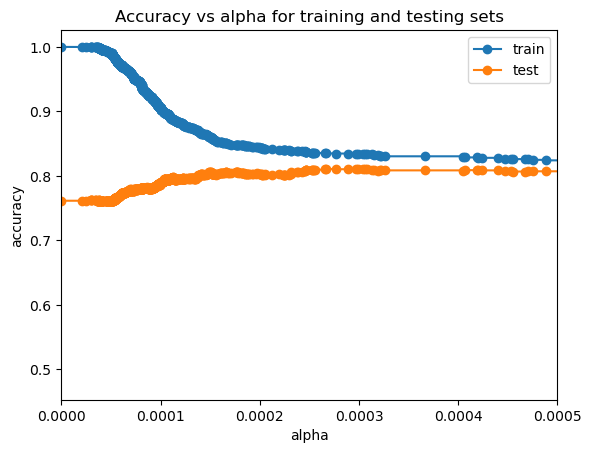

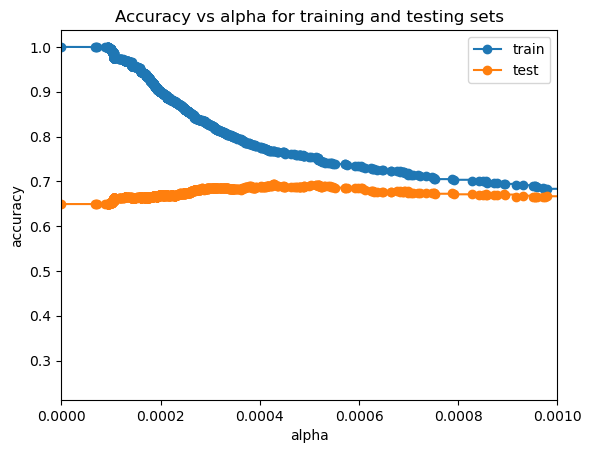

In [195]:
def run_all_cp(X_train1, y_train1, X_test1, y_test1, limit):
    X_test11, X_val1, y_test11, y_val1 = need_val_test(X_test1, y_test1)

    res = impurities_alphas(clf, X_train1, y_train1, False)
    plt.close("all") #this is the line to be added
    clfs = alphas_nodes_depth(res, X_train1, y_train1, False)
    plt.close("all") #this is the line to be added

    alpha_acc(clfs, X_train1, y_train1, X_val1, y_val1, res, limit)
    plt.close("all") #this is the line to be added
    
run_all_cp(X_train1, y_train1, X_test1, y_test1, 0.0005)
run_all_cp(X_train2, y_train2, X_test2, y_test2, 0.001)

In [196]:
def postpruning(X_train1, y_train1, X_test1, y_test1, perfect_a, d_name="census pay"):
    clf = DecisionTreeClassifier(random_state=10, ccp_alpha = perfect_a)
    
    start = time.time()
    clf.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")

    training_score = clf.score(X_train1, y_train1)
    
    start = time.time()
    testing_score = clf.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    print("Scoring time", round(testingtime, 4), "seconds")
    
    print("Dataset", d_name)
    print("Training Accuracy", training_score)
    print("Testing Accuracy", testing_score)
    show_tree(X_train1, clf, show=False, name="DTcensus_postpruned.png")
    print_tree_atts(clf)
    return clf

ppclf1 = postpruning(X_train1, y_train1, X_test1, y_test1, 0.00025)
print("----------------------------------------------------")
ppclf2 = postpruning(X_train2, y_train2, X_test2, y_test2, 0.0004, "Body_performance")

Training time 0.1162 seconds
Scoring time 0.0051 seconds
Dataset census pay
Training Accuracy 0.8362991500030575
Testing Accuracy 0.8159509202453987
Max depth 13
Number of nodes 165
DecisionTreeClassifier(ccp_alpha=0.00025, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')
----------------------------------------------------
Training time 0.1116 seconds
Scoring time 0.0024 seconds
Dataset Body_performance
Training Accuracy 0.777789630893962
Testing Accuracy 0.6896465903434544
Max depth 13
Number of nodes 497
DecisionTreeClassifier(ccp_alpha=0.0004, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_

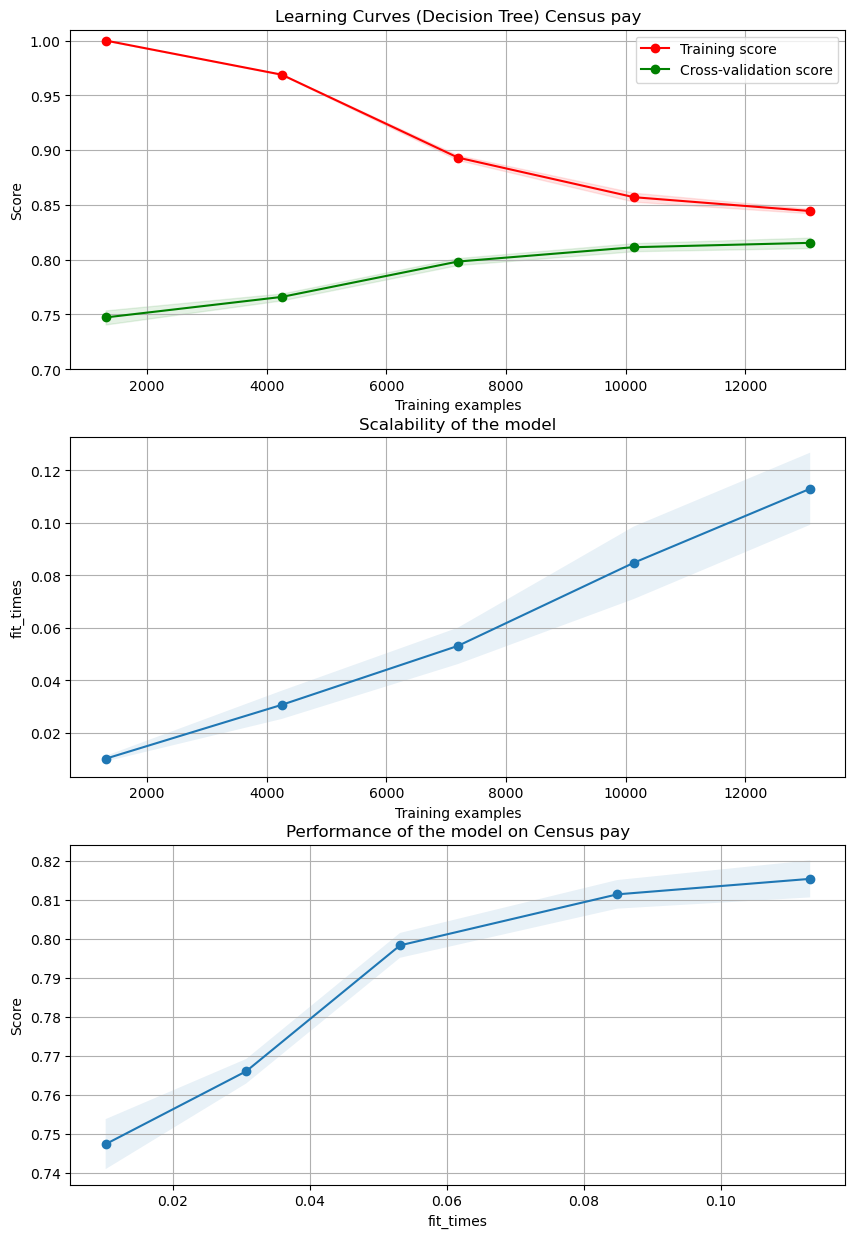

In [203]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,  n_jobs=None, scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5), d_name="Census pay"):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    tit = title +" " + d_name
    axes[0].set_title(tit)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    tit = "Performance of the model on "+d_name
    axes[2].set_title(tit)

    plt.show()

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
title="Learning Curves (Decision Tree)"

plot_learning_curve( ppclf1, title,  X_train1,  y_train1, axes=axes,  ylim=(0.7, 1.01),  cv=5,  n_jobs=4,
    scoring="accuracy", d_name="Census pay")

# plot_learning_curve( ppclf2, title,  X_train2,  y_train2, axes=axes,  ylim=(0.5, 1.01),  cv=5,  n_jobs=4,
#     scoring="accuracy", d_name="Body Performance")



## KNN classifier

In [322]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train1, y_train1)
x_scaled1 = scaler.transform(X_train1)
x_scaled1 = pd.DataFrame(x_scaled1, columns=X_train1.columns)
xtest_scaled1 = scaler.transform(X_test1)
xtest_scaled1 = pd.DataFrame(xtest_scaled1, columns=X_train1.columns)

scaler = StandardScaler()
scaler.fit(X_train2, y_train2)
x_scaled2 = scaler.transform(X_train2)
x_scaled2 = pd.DataFrame(x_scaled2, columns=X_train2.columns)
xtest_scaled2 = scaler.transform(X_test2)
xtest_scaled2 = pd.DataFrame(xtest_scaled2, columns=X_train2.columns)

def scoring_wo_cons_knn(X_train1, y_train1, X_test1, y_test1):
    neigh = KNeighborsClassifier()
    start = time.time()
    neigh.fit(X_train1, y_train1)
    end = time.time()
    trainingtime = end - start
    print("Training time", round(trainingtime, 4), "seconds")
    
    train_sc = neigh.score(X_train1, y_train1)
    
    start = time.time()
    test_sc = neigh.score(X_test1, y_test1)
    end = time.time()
    testingtime = end - start
    print("Testing time", round(testingtime, 4), "seconds")
    
    print("Training score w/o GS", train_sc)
    print("Testing score w/o GS", test_sc)
    return neigh

# ---------------------------------------------------------------- #

print("Dataset1: Census pay")
clf1=scoring_wo_cons_knn(x_scaled1, y_train1, xtest_scaled1, y_test1)
print(clf1)
print("------------------------------------------")
print("Dataset2: Body performance")
clf2=scoring_wo_cons_knn(x_scaled2, y_train2, xtest_scaled2, y_test2)


Dataset1: Census pay
Training time 0.0374 seconds
Testing time 1.8268 seconds
Training score w/o GS 0.8471840029352412
Testing score w/o GS 0.7838493365672706
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
------------------------------------------
Dataset2: Body performance
Training time 0.0132 seconds
Testing time 0.421 seconds
Training score w/o GS 0.7163430765948368
Testing score w/o GS 0.5960676953708313


In [325]:
# -------------------------------------- dataset 1 ----------------------
k_range = list(range(1,100,8))
metric = ['hamming', 'minkowski', 'euclidean']
# wei_range = ['uniform', 'distance']
leaf_s_range = list(range(1,50,5))


# knn = KNeighborsClassifier()
# val_curve(knn, x_scaled1, y_train1, param_name='metric', param_range=metric, scoring = "accuracy", 
#           ds_name='Body Performance')

# knn = KNeighborsClassifier(metric='minkowski')
# val_curve(knn, x_scaled2, y_train2, param_name='n_neighbors', param_range=k_range, scoring = "accuracy", 
#           ds_name='Body Performance')


# val_curve(knn, x_scaled1, y_train1, param_name='weights', param_range=wei_range, scoring = "accuracy", 
#           ds_name='Body Performance')


knn = KNeighborsClassifier(metric = "minkowski", weights='uniform', n_neighbors=15)
start = time.time()
knn.fit(x_scaled1, y_train1)
end = time.time()
trtime = end - start 

trs = knn.score(x_scaled1, y_train1)
s = time.time()
ts = knn.score(xtest_scaled1, y_test1)
e = time.time()
tt = e - s

print("----------------------------------------------------------")
print("Prepruned knn for Dataset1: Census pay")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)
print(knn)

----------------------------------------------------------
Prepruned knn for Dataset1: Census pay
Training time 0.0329  Testing time 2.1375 seconds
Training score 0.8181373448296949  Testing score 0.789841632187188
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')


### Testing theory that reducing features improves accuracy (Data 1)
For dataset 1, selecting a few columns and testing with different values to check how different is the accuracy. 

In [343]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

def knn_reduce_feats(X_train1, y_train1, X_test1, y_test1, method = "columns", columns = [], nfeats=8 ) :
    if method == f_classif or method == chi2:
        selector = SelectKBest(method, k=nfeats)
        model = selector.fit(X_train1, y_train1)
        cols = model.get_support(indices=True)
        features_df_new = X_train1.iloc[:,cols]
        print(features_df_new.columns)

        X_new = model.transform(X_train1)
        test_new = selector.transform(X_test1)
    else:
        X_new = X_train1[columns]
        X_new.loc[:,'age'] = 0.7*X_new.loc[:,'age']
        test_new = X_test1[columns]
        test_new.loc[:,'age'] = 0.7* test_new.loc[:,'age']


    neigh = KNeighborsClassifier()
    params_to_tune = {'n_neighbors':[10, 15, 18, 25], 'weights': [ 'uniform'],
                      'metric':['minkowski']
                     }

    rc = RandomizedSearchCV(neigh, params_to_tune,  n_iter=30, cv=5)
    neigh = rc.fit(X_new, y_train1)

    knn_best = neigh.best_estimator_

    tr_sc = knn_best.score(X_new, y_train1)
    test_sc = knn_best.score(test_new, y_test1)
    print("Training score:", tr_sc, " Testing score:", test_sc)

print("My own 8 columns")
columns = ['age', 'sex', 'occupation', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
knn_reduce_feats(X_train1, y_train1, X_test1, y_test1, "columns", columns)

My own 8 columns


/home/ai/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/ai/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=30. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training score: 0.8322020424386962  Testing score: 0.7962619489228135


In [327]:
# -------------- dataset 2---------------------------
k_range = list(range(1,100,8))
metric = ['hamming', 'minkowski', 'euclidean']
# wei_range = ['uniform', 'distance']
leaf_s_range = list(range(1,50,5))


# knn = KNeighborsClassifier()
# val_curve(knn, x_scaled1, y_train1, param_name='metric', param_range=metric, scoring = "accuracy", 
#           ds_name='Body Performance')

# knn = KNeighborsClassifier(metric='minkowski')
# val_curve(knn, x_scaled2, y_train2, param_name='n_neighbors', param_range=k_range, scoring = "accuracy", 
#           ds_name='Body Performance')


# val_curve(knn, x_scaled1, y_train1, param_name='weights', param_range=wei_range, scoring = "accuracy", 
#           ds_name='Body Performance')


knn = KNeighborsClassifier(metric = "minkowski", weights='distance', n_neighbors=25)
start = time.time()
knn.fit(x_scaled2, y_train2)
end = time.time()
trtime = end - start 

trs = knn.score(x_scaled2, y_train2)
s = time.time()
ts = knn.score(xtest_scaled2, y_test2)
e = time.time()
tt = e - s

print("----------------------------------------------------------")
print("Prepruned knn for Dataset2: Body Performance")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)


----------------------------------------------------------
Prepruned knn for Dataset2: Body Performance
Training time 0.0197  Testing time 0.4612 seconds
Training score 1.0  Testing score 0.6331508213041314


### Changing weights of the columns to achieve better results (Data 2)

In [313]:
columns = ['age', 'gender', 'weight_kg', 'body fat_%', 'gripForce','sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm' ]
knn = KNeighborsClassifier(metric = "minkowski", weights='distance', n_neighbors=25)

xscaled_sel = x_scaled2.loc[:, columns]
xtest_scaled2_sel = xtest_scaled2.loc[:, columns]

# 0.6294176207068193 if we give more importance to important feats
c=3
xscaled_sel['sit and bend forward_cm']= c*xscaled_sel['sit and bend forward_cm']
xscaled_sel['sit-ups counts']=c*0.9*xscaled_sel['sit-ups counts']
xscaled_sel['broad jump_cm']= 0.4*xscaled_sel['broad jump_cm']


xtest_scaled2_sel['sit and bend forward_cm']= c*xtest_scaled2_sel['sit and bend forward_cm']
xtest_scaled2_sel['sit-ups counts']= c*0.9*xtest_scaled2_sel['sit-ups counts']
xtest_scaled2_sel['broad jump_cm']= 0.4*xtest_scaled2_sel['broad jump_cm']

knn = KNeighborsClassifier(metric='minkowski', n_neighbors=15, weights='uniform')
start = time.time()
knn.fit(xscaled_sel, y_train2)
end = time.time()
trtime = end - start 

trs = knn.score(xscaled_sel, y_train2)
s = time.time()
ts = knn.score(xtest_scaled2_sel, y_test2)
e = time.time()
tt = e - s
print("----------------------------------------------------------")
print("Prepruned knn for Dataset2: Body Performance")
print("Training time", round(trtime, 4), " Testing time", round(tt, 4), "seconds")
print("Training score", trs, " Testing score", ts)


----------------------------------------------------------
Prepruned knn for Dataset2: Body Performance
Training time 0.0153  Testing time 0.181 seconds
Training score 0.7311713249413271  Testing score 0.7013439522150323


## Neural Networks

Training score: 0.8003396480543437  Testing score: 0.7981143676982988


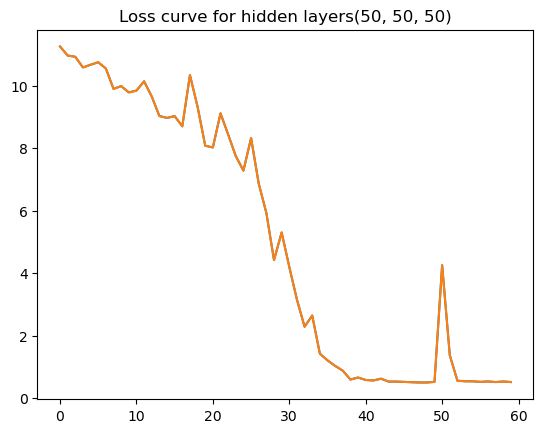

Training score: 0.7944543671126988  Testing score: 0.7903258864521419


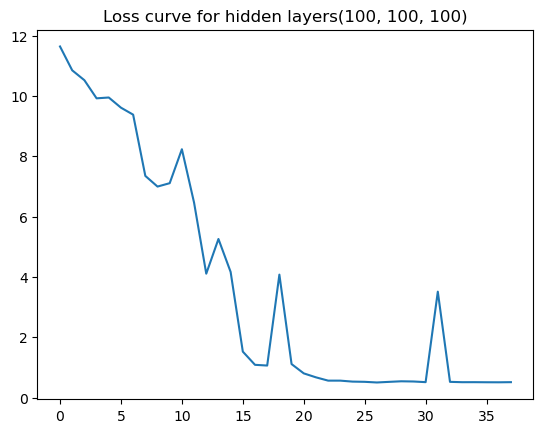

Training score: 0.7978215676514508  Testing score: 0.7987975678076108


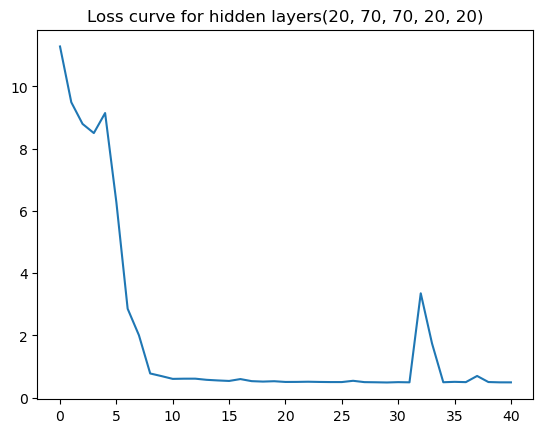

Training score: 0.7988756478201037  Testing score: 0.7946983671517387


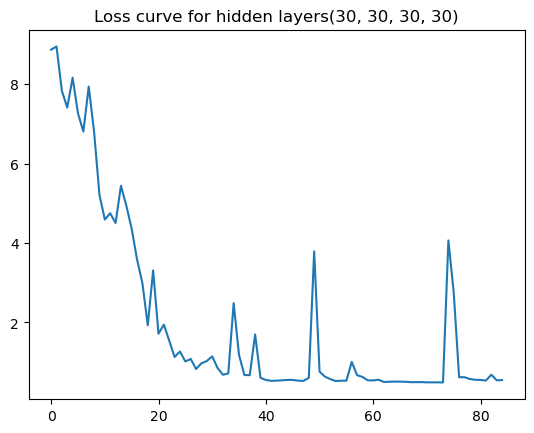

Training score: 0.7937809270049483  Testing score: 0.7945617271298764


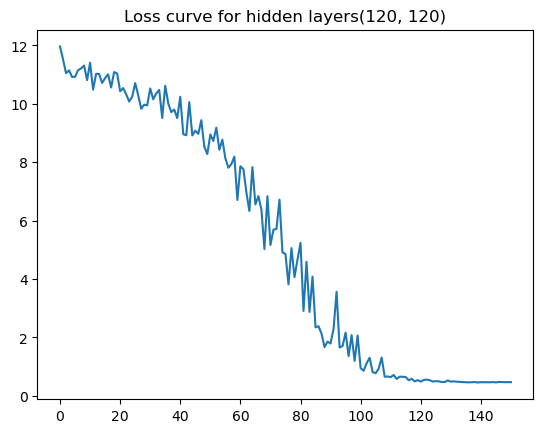

In [27]:
from sklearn.neural_network import MLPClassifier
#--- relu does better than tanh and logistic or use smaller learning rate for logistica nd tanh
params = [
    {'solver':'adam', 'learning_rate_init':0.001, 'learning_rate' : 'adaptive', 'activation':'relu'},
    {'solver':'adam', 'learning_rate_init':0.0001, 'learning_rate': 'adaptive', 'activation' : 'logistic'},
    {'solver':'adam', 'learning_rate_init':0.0001, 'learning_rate': 'adaptive', 'activation' : 'tanh'}
]

params = [
    {'hidden_layer_sizes': (50, 50, 50)},
#     {'hidden_layer_sizes': (100,100, 100)},
#     {'hidden_layer_sizes': (20, 70, 70, 20, 20)},
#     {'hidden_layer_sizes': (30, 30, 30, 30)},
#     {'hidden_layer_sizes': (120, 120)},

]


for param in params:
    clf = MLPClassifier(**param , random_state=10, max_iter=300, solver='adam', learning_rate_init=0.001, 
    learning_rate='adaptive',activation='relu')
    clf.fit(X_train1, y_train1)
    trs = clf.score(X_train1, y_train1)
    ts = clf.score(X_test1, y_test1)
    print("Training score:", trs, " Testing score:", ts)
    plt.plot(clf.loss_curve_)
    tit = "Loss curve for hidden layers" + str(param['hidden_layer_sizes'])
    plt.title(tit)
    plt.show()

# solver='adam', learning_rate_init=0.001,  learning_rate='adaptive',activation='relu'
# layers_nodes 50 50 50 Training score: 0.8003396480543437  Testing score: 0.7981143676982988
# layers_nodes 100 100 100 Training score: 0.7944543671126988  Testing score: 0.7903258864521419
# layers_nodes 20 70 70 20 20 Training score: 0.7978215676514508  Testing score: 0.7987975678076108
# layers_nodes 30 30 30 30 Training score: 0.7988756478201037  Testing score: 0.7946983671517387
# layers_nodes 120 120  Training score: 0.7937809270049483  Testing score: 0.7945617271298764

In [68]:
data2['class'].value_counts()

C    3349
D    3349
A    3347
B    3347
Name: class, dtype: int64

In [332]:
data1.corr()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Result
age,1.000000,0.047400,-0.066499,0.017417,0.076406,-0.262579,-0.000408,-0.257196,0.043556,0.133671,0.086680,0.056855,0.058897,0.001543,0.285174
workclass,0.047400,1.000000,-0.019209,-0.002953,0.006462,-0.011972,0.026953,-0.044822,0.050260,0.059646,0.042499,0.016227,0.051065,-0.005872,-0.005109
fnlwgt,-0.066499,-0.019209,1.000000,-0.006475,-0.024825,0.033150,0.008633,0.004194,-0.026904,0.024142,-0.005186,-0.003091,-0.011807,-0.043100,-0.010375
education,0.017417,-0.002953,-0.006475,1.000000,0.284338,-0.047757,-0.024594,-0.027464,0.019877,-0.009183,0.036057,0.018737,0.061541,0.059891,0.101786
education-num,0.076406,0.006462,-0.024825,0.284338,1.000000,-0.096476,0.118951,-0.111886,0.037639,0.050093,0.142628,0.097258,0.166214,0.053083,0.382952
marital-status,-0.262579,-0.011972,0.033150,-0.047757,-0.096476,1.000000,-0.001707,0.183615,-0.070113,-0.138953,-0.042415,-0.039270,-0.178441,-0.016644,-0.251884
occupation,-0.000408,0.026953,0.008633,-0.024594,0.118951,-0.001707,1.000000,-0.073278,0.009307,0.069844,0.024006,0.022823,0.066342,-0.008286,0.069495
relationship,-0.257196,-0.044822,0.004194,-0.027464,-0.111886,0.183615,-0.073278,1.000000,-0.108291,-0.664573,-0.050277,-0.055683,-0.259722,-0.020971,-0.290971
race,0.043556,0.050260,-0.026904,0.019877,0.037639,-0.070113,0.009307,-0.108291,1.000000,0.088964,0.008330,0.017595,0.054264,0.152559,0.084936
sex,0.133671,0.059646,0.024142,-0.009183,0.050093,-0.138953,0.069844,-0.664573,0.088964,1.000000,0.045292,0.048807,0.244550,0.014440,0.263740


In [ ]:
columns = ['weight_kg', 'body fat_%', 'gripForce','sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm' ]